In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:38057")
client

<Client: 'tcp://127.0.0.1:38057' processes=8 threads=32, memory=125.89 GiB>

In [ ]:
client.restart()

In [6]:
import numpy as np
import xarray as xr
import pandas as pd
import os.path as op
import os
import xrft
import xwavelet
from scipy.interpolate import griddata
from scipy.stats import bootstrap
from xgcm.grid import Grid
from xmitgcm import open_mdsdataset
# from fastjmd95 import rho as densjmd95
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
ddir = '/tank/groups/climode/qjamet/RUNS/ORAR/reruns2/'
gdir = '/tank/chaocean/grid_chaO/gridMIT_update1/'
savedir = '/tank/topog/tuchida/Wavelet-spectrum/'
tdgs = '/tank/tdgs/tuchida/TWA/'
topog = '/tank/topog/tuchida/TWA/'

In [5]:
grav = 9.81
nensembs = 5
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
# Cp = 3.994e3
Cp = 3989.244953
# years = np.arange(2008,2013,dtype=int)
ySstart = -15
yNstart = 15
yend = 50
dnf = 2160
nfile = 73

In [41]:
import numpy as np
rng = np.random.default_rng()
from scipy.stats import norm
dist = norm(loc=2, scale=4)  # our "unknown" distribution
data = dist.rvs(size=(48,50), random_state=rng)
data.shape

(48, 50)

In [42]:
mn_true = dist.mean()      # the true value of the statistic
print(mn_true)
mn_sample = data.mean(axis=0)  # the sample statistic
print(mn_sample)

2.0
[1.11371789 2.05753535 2.679691   2.19274911 2.08592416 2.92727947
 2.73560817 2.02383322 1.3318834  1.42376577 1.85787607 1.87410986
 2.46899567 1.37960213 1.20319103 2.39588583 1.49057247 2.55074406
 1.531248   1.93332719 1.78746759 2.51265986 1.95546493 2.17606819
 2.0781455  2.09263627 3.01801526 2.15215434 1.6972348  1.13159203
 1.8423488  1.41659632 1.82308588 1.94337771 2.51655151 1.51400208
 2.73429909 0.90981924 0.82784063 1.36945111 1.67417439 1.40046279
 1.93979903 2.89191813 1.44834495 2.20143406 1.44970416 1.70044032
 1.90906214 1.80217643]


In [36]:
print(mn_sample.mean())

2.003472393528352


In [44]:
datas = (data,)  # samples must be in a sequence
res = bootstrap(datas, np.mean, confidence_level=0.95,
                random_state=rng)
print(res.confidence_interval)

ConfidenceInterval(low=array([-0.01532472,  0.77657032,  1.50399725,  1.17242584,  0.8878896 ,
        1.60451276,  1.68269625,  1.02150788,  0.22622436,  0.44917189,
        0.817536  ,  0.8732789 ,  1.55397272,  0.13896666,  0.15883754,
        1.17535818,  0.30341663,  1.45764724,  0.18197864,  0.94092931,
        0.74082575,  1.42238069,  0.91085476,  1.00736789,  0.77541587,
        0.84433559,  1.95534989,  1.0671966 ,  0.51127031,  0.24367931,
        0.54917924,  0.22999798,  0.90321049,  0.71415051,  1.41679696,
        0.30939758,  1.58101662, -0.03588155, -0.25753076,  0.17352919,
        0.56108382,  0.3134705 ,  0.82606464,  1.76666689,  0.39729465,
        0.91410392,  0.39284497,  0.58324501,  0.75026801,  0.82472497]), high=array([2.15200151, 3.3901678 , 3.90287167, 3.20600606, 3.2565527 ,
       4.32847019, 3.85779048, 2.88550425, 2.31625788, 2.40735351,
       2.938692  , 2.82656188, 3.32366864, 2.39742887, 2.21840013,
       3.62857507, 2.65929256, 3.77635539, 2.7096

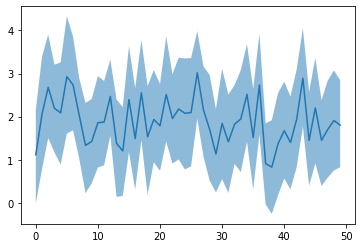

In [45]:
plt.plot(range(50), mn_sample)
plt.fill_between(range(50), res.confidence_interval.low, res.confidence_interval.high, alpha=.5)

In [ ]:
nmembs = np.arange(100,148)

for nmemb in nmembs:
    if nmemb == 100:
        ds = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                         % (nmemb)), 
                                 grid_dir=gdir,
                                 prefix=['snap_diagOcn'], delta_t=2e2,
                                 iters=1419123, 
                                ).isel(time=0).sel(YC=slice(ys[reg]-5-dg/12,ys[reg]+5+dg/12),
                                                   YG=slice(ys[reg]-5-dg/12,ys[reg]+5+dg/12),
                                                   XC=slice(xs[reg]-5-dg/12,xs[reg]+5+dg/12),
                                                   XG=slice(xs[reg]-5-dg/12,xs[reg]+5+dg/12)
                                                  )
    else:
        ds = xr.concat([ds, open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                                        % (nmemb)), 
                                                grid_dir=gdir,
                                                prefix=['snap_diagOcn'], delta_t=2e2,
                                                iters=1419123, 
                                               ).isel(time=0).sel(YC=slice(ys[reg]-5-dg/12,ys[reg]+5+dg/12),
                                                                  YG=slice(ys[reg]-5-dg/12,ys[reg]+5+dg/12),
                                                                  XC=slice(xs[reg]-5-dg/12,xs[reg]+5+dg/12),
                                                                  XG=slice(xs[reg]-5-dg/12,xs[reg]+5+dg/12)
                                                                 )
                           ], dim='nmemb')

            # ds = ds.chunk({'nmemb':6})
ds.coords['nmemb'] = ('nmemb',nmembs)

u = ds.UVEL
v = ds.VVEL

ism=201;ilg=500;
jsm=600;jlg=750;
for i in range(ism-1,ilg):
	for j in range(jsm-1,jlg):
		iic=i-ism+1;
		jjc=j-jsm+1;
		m=bootstrp(1000,@mean,squeeze(u(i,j,:)));
		n=bootstrp(1000,@mean,squeeze(v(i,j,:)));
		[fiu,xiu]=ksdensity(m);
		[fiv,xiv]=ksdensity(n);
		zu=cumsum(fiu)*(xiu(end)-xiu(1))/99;
		zv=cumsum(fiv)*(xiv(end)-xiv(1))/99;
		iiii=1;
		while zu(iiii)< .025;
			iiii=iiii+1;
		end;
		ul(iic,jjc)=xiu(iiii);
		iiii=1;
		while zu(iiii) < .975;
			iiii=iiii+1;
		end;
		uu(iic,jjc)=xiu(iiii);
		iiii=1;
		while zv(iiii)< .025;
			iiii=iiii+1;
		end;
		vl(iic,jjc)=xiv(iiii);
		iiii=1;
		while zv(iiii) < .975;
			iiii=iiii+1;
		end;
		vu(iic,jjc)=xiv(iiii);

end;
end;
um=sum(u(ism:ilg,jsm:jlg),3)/48;
vm=sum(v(ism:ilg,jsm:jlg),3)/48;
end;
end;

